In [ ]:
from data_utils import load_dataset
import torch
import os
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
# os.environ['http_proxy'] = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

The code comes from https://github.com/tonyzhaozh/few-shot-learning

In [ ]:
# !pip install openai

In [ ]:
import numpy as np
import time
from copy import deepcopy
import os
import sys
import torch
import pickle
import openai
from transformers import GPT2Tokenizer, GPT2LMHeadModel
# os.environ['http_proxy'] = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'
# from transformers import BertTokenizer, BertLMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# # tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# ROOT_DIR = os.path.dirname(os.path.realpath(__file__))
# SAVE_DIR = os.path.join(ROOT_DIR, 'saved_results')
SAVE_DIR =  './saved_results'
if not os.path.isdir(SAVE_DIR):
    os.mkdir(SAVE_DIR)
    print(f"mkdir at {SAVE_DIR} for saving results")

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def chunk_size_helper(params):
    # Set the batch size (the size of the chunks determines the batch size). Default to 4 for GPT-2 and 20 for OpenAI if
    # no batch size is specified.
    bs = params['bs']
    if bs is None:
        if 'gpt2' in params['model']:
        # if 'bert' in params['model']:
            return 1
        else:
            assert params['model'] in ['ada', 'babbage', 'curie', 'davinci', 'ada-beta', 'babbage-beta', 'curie-beta', 'davinci-beta']
            return 20
    else:
        return bs

def random_sampling(sentences, labels, num):
    """randomly sample subset of the training pairs"""
    assert len(sentences) == len(labels)
    if num > len(labels):
        assert False, f"you tried to randomly sample {num}, which is more than the total size of the pool {len(labels)}"
    idxs = np.random.choice(len(labels), size=num, replace=False)
    selected_sentences = [sentences[i] for i in idxs]
    selected_labels = [labels[i] for i in idxs]
    return deepcopy(selected_sentences), deepcopy(selected_labels)

gpt2_model = None
gpt2_tokenizer = None
def setup_gpt2(model_name):
    # load the GPT-2 model
    global gpt2_model
    global gpt2_tokenizer
    if gpt2_model is None:
        print("Setting up GPT-2 model")
        gpt2_model = GPT2LMHeadModel.from_pretrained(model_name)
        
        gpt2_model.eval().to(device)
        # gpt2_model.eval()
        
        gpt2_tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        # to batch generation, we pad on the left and mask those positions out.
        gpt2_tokenizer.padding_side = "left"
        gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
        gpt2_model.config.pad_token_id = gpt2_model.config.eos_token_id
        num_params = sum(p.numel() for p in gpt2_model.parameters())
        print("number of model parameters: ", num_params)
        print("Finished")

def complete_gpt2(prompt, l=10, model_name='gpt2-xl', num_log_probs=None, echo=False):
    ''' This function runs GPT-2 locally but places the outputs into an json that looks just like the one
     provided by the OpenAI API. '''
    if isinstance(prompt, str):
        prompt = [prompt] # the code below assumes a list
    input_ids = gpt2_tokenizer.batch_encode_plus(prompt, return_tensors="pt", padding=True)
    # print(l + len(input_ids['input_ids'][0]))
    # print("this is prompt: ",(prompt))
    # print("-"*100)
    # greedily generate l tokens
    if l > 0:
        # the generate function can handle left padded inputs automatically in HF
        # total_sequences is now the input + possible generated output
        # total_sequences = gpt2_model.generate(input_ids=input_ids['input_ids'].cuda(), attention_mask=input_ids['attention_mask'].cuda(), max_length=l + len(input_ids['input_ids'][0]), do_sample=False)
        total_sequences = gpt2_model.generate(input_ids=input_ids['input_ids'].to(device), attention_mask=input_ids['attention_mask'].to(device), max_length=l + len(input_ids['input_ids'][0]), do_sample=False)
    else:
        assert echo == True and l == 0
        # total_sequences = input_ids['input_ids'].cuda()
        total_sequences = input_ids['input_ids'].to(device)
    # print("total_sequences: ",total_sequences.shape)
    # they want the probs of the top tokens
    if num_log_probs is not None:
        # we are left padding, so we need to adjust the position IDs
        attention_mask = (total_sequences != 50256).float()
        position_ids = attention_mask.long().cumsum(-1) - 1
        position_ids.masked_fill_(attention_mask == 0, 1)
        # get the logits for the context and the next l tokens
        logits = gpt2_model.forward(input_ids=total_sequences, attention_mask=attention_mask, position_ids=position_ids, return_dict=True).logits.detach().cpu()
        if not echo:
            # get the top tokens and probs for the generated l tokens
            probs = torch.softmax(logits[:,-l-1:], dim=2).cpu()
        else:
            # get the top tokens and probs for the context and the generated l tokens
            probs = torch.softmax(logits, dim=2).cpu()
        top_probs, top_tokens = torch.topk(probs, k=num_log_probs)
        logprobs = torch.log(probs)
        top_log_probs = torch.log(top_probs)
        # print("this is toplogprobs",top_log_probs)
        # print("this is toptoken",top_tokens)
    # create the return value to resemble OpenAI
    return_json = {}
    choices = []
    for batch_id in range(len(prompt)):
        curr_json = {}
        # text is just the optional context and next l tokens
        if not echo:
            curr_json['text'] = gpt2_tokenizer.decode(total_sequences[batch_id][-l:], skip_special_tokens=True)
        else:
            curr_json['text'] = gpt2_tokenizer.decode(total_sequences[batch_id], skip_special_tokens=True)

        # fill the return json with the top tokens and probs to match the OpenAI return value.
        if num_log_probs is not None:
            curr_json['logprobs'] = {}
            curr_json['logprobs']['top_logprobs'] = []
            curr_json['logprobs']['token_logprobs'] = []
            curr_json['logprobs']['tokens'] = []
            if not echo:
                # cutoff the -1 here because the probs are shifted one over for LMs
                for current_element_top_log_probs, current_element_top_tokens in zip(top_log_probs[batch_id][:-1], top_tokens[batch_id][:-1]):
                    # tokens is a list of the top token at each position
                    curr_json['logprobs']['tokens'].append(gpt2_tokenizer.decode([current_element_top_tokens[0]]))
                    # token_logprobs is a list of the logprob of the top token at each position
                    curr_json['logprobs']['token_logprobs'].append(current_element_top_log_probs[0].item())
                    # top_logprobs is a list of dicts for the top K tokens. with each entry being {'token_name': log_prob}
                    temp = {}
                    for log_prob, token in zip(current_element_top_log_probs, current_element_top_tokens):
                        temp[gpt2_tokenizer.decode(token.item())] = log_prob.item()
                    curr_json['logprobs']['top_logprobs'].append(temp)
            else:
                # same as not above but small tweaks
                # we add null to the front because for the GPT models, they have null probability for the first token
                # (for some reason they don't have an beginning of sentence token)
                curr_json['logprobs']['top_logprobs'].append('null')
                # cutoff the -1 here because the probs are shifted one over for LMs
                for index, (current_element_top_log_probs, current_element_top_tokens) in enumerate(zip(top_log_probs[batch_id][:-1], top_tokens[batch_id][:-1])):
                    # skip padding tokens
                    if total_sequences[batch_id][index].item() == 50256:
                        continue
                    temp = {}
                    for log_prob, token in zip(current_element_top_log_probs, current_element_top_tokens):
                        temp[gpt2_tokenizer.decode(token.item())] = log_prob.item()
                    curr_json['logprobs']['top_logprobs'].append(temp)
                for index in range(len(probs[batch_id])):
                    curr_json['logprobs']['tokens'].append(gpt2_tokenizer.decode([total_sequences[batch_id][index]]))
                curr_json['logprobs']['token_logprobs'].append('null')
                for index, log_probs_token_position_j in enumerate(logprobs[batch_id][:-1]):
                    # probs are left shifted for LMs 
                    curr_json['logprobs']['token_logprobs'].append(log_probs_token_position_j[total_sequences[batch_id][index+1]])

        choices.append(curr_json)
    return_json['choices'] = choices
    return return_json

def complete(prompt, l, model, temp=0, num_log_probs=None, echo=False, n=None):
    """complete the prompt using a language model"""
    assert l >= 0
    assert temp >= 0
    if 'gpt2' in model:
        assert n == None # unsupported at the moment
        assert temp == 0 # unsupported at the moment
        setup_gpt2(model)
        return complete_gpt2(prompt, l=l, model_name=model, num_log_probs=num_log_probs, echo=echo)
    else:
        setup_gpt3()
        return complete_gpt3(prompt, l=l, model_name=model, num_log_probs=num_log_probs, echo=echo, n=n)

def construct_prompt(params, train_sentences, train_labels, test_sentence):
    """construct a single prompt to be fed into the model"""
    # special case when the user defines a custom prompt function. 
    if ('prompt_func' in params.keys()) and (params['prompt_func'] is not None):
        return params['prompt_func'](params, train_sentences, train_labels, test_sentence)

    # take the prompt template and fill in the training and test example
    prompt = params["prompt_prefix"]
    q_prefix = params["q_prefix"]
    a_prefix = params["a_prefix"]
    for s, l in zip(train_sentences, train_labels):
        # print("s and l",s,l)
        # print("type:",type(s),type(l))
        prompt += q_prefix
        prompt += s + "\n"
        if isinstance(l, int) or isinstance(l, np.int32) or isinstance(l, np.int64): # integer labels for classification
            assert params['task_format'] == 'classification'
            l_str = params["label_dict"][l][0] if isinstance(params["label_dict"][l], list) else params["label_dict"][l]
            # print("enter if: ")
        else:
            assert isinstance(l, str) # string labels
            assert params['task_format'] == 'qa'
            l_str = l
            # print("enter else: ")
        # print("this is l_str",l_str)
        # print(type(l_str))
        prompt += a_prefix
        prompt += l_str + "\n\n"

    prompt += q_prefix
    prompt += test_sentence + "\n"
    assert a_prefix[-1] == ' '
    prompt += a_prefix[:-1] # GPT models do not want a trailing space, so we cut off -1
    return prompt

def get_model_response(params, train_sentences, train_labels, test_sentences, return_all_prompts=False,
                       num_tokens_to_predict_override=None, override_prompt=None):
    """
    Obtain model's responses on test sentences, given the training examples
    :param params: parameters for the experiment
    :param train_sentences: few-shot training sentences
    :param train_labels: few-shot training labels
    :param test_sentences: few-shot test sentences
    :param return_all_prompts: whether to return all the prompts
    :param num_tokens_to_predict_override: whether to override num token to predict
    :param override_prompt: whether to override prompt
    :return: a list of dictionaries
    """
    all_raw_answers = []

    # can optionally ignore the normal prompt and feed in a custom prompt (used for contextual calibration)
    if override_prompt is None:
        prompts = []
        for test_sentence in test_sentences:
            prompts.append(construct_prompt(params, train_sentences, train_labels, test_sentence))
    else:
        prompts = override_prompt

    chunked_prompts = list(chunks(prompts, chunk_size_helper(params)))
    for chunk_id, test_chunk_prompts in enumerate(chunked_prompts):
        if num_tokens_to_predict_override is not None:
            num_tokens_to_predict = num_tokens_to_predict_override
        else:
            num_tokens_to_predict = params['num_tokens_to_predict']
        resp = complete(test_chunk_prompts, num_tokens_to_predict, params['model'], num_log_probs=params['api_num_log_prob'])
        for answer_id, answer in enumerate(resp['choices']):
            all_raw_answers.append(answer)
    if return_all_prompts:
        return all_raw_answers, prompts
    else:
        return all_raw_answers

def load_pickle(params):
    # load saved results from model
    file_name = os.path.join(SAVE_DIR, f"{params['expr_name']}.pkl")
    assert os.path.isfile(file_name), f"file does not exist: {file_name}"
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    print(f"Loaded data from {file_name}")
    return data

def save_pickle(params, data):
    # save results from model
    file_name = os.path.join(SAVE_DIR, f"{params['expr_name']}.pkl")
    if os.path.isfile(file_name):
        print("WARNING! overwriting existing saved files")
    with open(file_name, 'wb') as file:
        pickle.dump(data, file)
    print(f"Saved to {file_name}")
    return data

def print_results(tree, names=('Original Accuracy  ','Calibrated Accuracy')):
    # print out all results
    root = deepcopy(tree)
    for dataset in root.keys():
        print(f"\n\nDataset: {dataset}")
        models_node = root[dataset]
        for model in models_node.keys():
            print(f"\nModel: {model}")
            num_shots_node = models_node[model]
            for num_shots in num_shots_node.keys():
                accuracies = np.array(list(num_shots_node[num_shots].values()))
                accuracies_mean = np.mean(accuracies, axis=0)
                accuracies_low = np.min(accuracies, axis=0)
                accuracies_high = np.max(accuracies, axis=0)
                accuracies_std = np.std(accuracies, axis=0)

                print(f"\n{num_shots}-shot, {len(accuracies)} seeds")
                for i, (m, l, h, s) in enumerate(zip(accuracies_mean, accuracies_low, accuracies_high, accuracies_std)):
                    print(f"{names[i]} | Mean: {m:.4f}, Low: {l:.4f}, High: {h:.4f}, Std: {s:.4f}")
                print()

def load_results(params_list):
    # load saved results from model
    result_tree = dict()
    for params in params_list:
        saved_result = load_pickle(params)
        keys = [params['dataset'], params['model'], params['num_shots']]
        node = result_tree # root
        for k in keys:
            if not (k in node.keys()):
                node[k] = dict()
            node = node[k]
        node[params['seed']] = saved_result['accuracies']
    print_results(result_tree)

In [ ]:
def save_result(params_list, freeze_test_set=True):
    """
    Run the model and save its responses and the rest of configs into a pickle file
    """
    # print("here")
    result_tree = dict()
    for param_index, params in enumerate(params_list):
        print("\nExperiment name:", params['expr_name'])

        ### load data
        all_train_sentences, all_train_labels, all_test_sentences, all_test_labels = load_dataset(params)
        # params_check(params)
       
        ### sample test set
        if params['subsample_test_set'] is None:
            test_sentences, test_labels = all_test_sentences, all_test_labels
            print(f"selecting full test set ({len(all_test_labels)} examples)")
        else:
            if freeze_test_set:
                np.random.seed(0) # always use seed 0 result if freeze
            else:
                np.random.seed(params['seed'])
            test_sentences, test_labels = random_sampling(all_test_sentences, all_test_labels, params['subsample_test_set'])
            print(f"selecting {len(test_labels)} subsample of test set")
        # print("this is test_sentence",test_sentences)
        # print("this is test label",test_labels)
        ### sample few-shot training examples
        np.random.seed(params['seed'])
        train_sentences, train_labels = random_sampling(all_train_sentences, all_train_labels, params['num_shots'])
        # print("this is train_sentence",train_sentences)
        # print("this is train label",train_labels)
        ### Evaluate the performance and save all results
        # obtaining model's response on test examples
        print(f"getting raw resp for {len(test_sentences)} test sentences")
        raw_resp_test = get_model_response(params, train_sentences, train_labels, test_sentences)
        # print("this is raw resp test",raw_resp_test)
        # get prob for each label
        all_label_probs = get_label_probs(params, raw_resp_test, train_sentences, train_labels, test_sentences)
        # print("this is all_label_probs",all_label_probs)
        # calculate P_cf
        content_free_inputs = ["N/A", "", "[MASK]"]
        p_cf = get_p_content_free(params, train_sentences, train_labels, content_free_inputs=content_free_inputs)
        acc_original = eval_accuracy(all_label_probs, test_labels)
        acc_calibrated = eval_accuracy(all_label_probs, test_labels, mode="diagonal_W", p_cf=p_cf)
        accuracies = [acc_original, acc_calibrated]
        print(f"Accuracies: {accuracies}")
        print(f"p_cf      : {p_cf}")

        # add to result_tree
        keys = [params['dataset'], params['model'], params['num_shots']]
        node = result_tree # root
        for k in keys:
            if not (k in node.keys()):
                node[k] = dict()
            node = node[k]
        node[params['seed']] = accuracies

        # save to file
        result_to_save = dict()
        params_to_save = deepcopy(params)
        result_to_save['params'] = params_to_save
        result_to_save['train_sentences'] = train_sentences
        result_to_save['train_labels'] = train_labels
        result_to_save['test_sentences'] = test_sentences
        result_to_save['test_labels'] = test_labels
        result_to_save['raw_resp_test'] = raw_resp_test
        result_to_save['all_label_probs'] = all_label_probs
        result_to_save['p_cf'] = p_cf
        result_to_save['accuracies'] = accuracies
        if 'prompt_func' in result_to_save['params'].keys():
            params_to_save['prompt_func'] = None
        save_pickle(params, result_to_save)

    print_results(result_tree)

In [ ]:
def eval_accuracy(all_label_probs, test_labels, mode=None, p_cf=None):
    # evaluate the accuracy with and without contextual calibration
    num_classes = all_label_probs.shape[1]
    if p_cf is None:
        # do not calibrate
        W = np.identity(num_classes)
        b = np.zeros([num_classes, 1])
    else:
        # calibrate
        if mode == "diagonal_W":
            W = np.linalg.inv(np.identity(num_classes) * p_cf)
            b = np.zeros([num_classes, 1])
        elif mode == "identity_W":
            W = np.identity(num_classes)
            b = -1 * np.expand_dims(p_cf, axis=-1)
        else:
            assert False

    correctness_list = []
    assert len(all_label_probs) == len(test_labels)
    for label_probs, true_label in zip(all_label_probs, test_labels):
        label_probs = label_probs / np.sum(label_probs) # normalize to 1

        calibrate_label_probs = np.matmul(W, np.expand_dims(label_probs, axis=-1)) + b

        ans_label = np.argmax(calibrate_label_probs)
        if ans_label == true_label:
            correctness_list.append(1)
        else:
            correctness_list.append(0)
    return np.mean(correctness_list)

def get_label_probs(params, raw_resp, train_sentences, train_labels, test_sentences):
    """Obtain model's label probability for each of the test examples. The returned prob is NOT normalized"""
    num_classes = len(params['label_dict'])
    approx = params['approx']
    assert len(raw_resp) == len(test_sentences)

    # Fill in the labels that is in the top k prob
    all_label_probs = []
    all_missing_positions = []
    for i, ans in enumerate(raw_resp):
        # print("this is ans")
        # print(ans)
        top_logprobs = ans['logprobs']['top_logprobs'][0]  # [0] since we only ask for complete one more token
        # print("this is top_logprobs")
        # print(top_logprobs)
        label_probs = [0] * len(params['label_dict'].keys())
        for j, label_list in params['label_dict'].items():
            all_found = True
            for label in label_list:  # each possible label correspond to the same class
                label = " " + label  # notice prompt does not have space after 'A:'
                if label in top_logprobs:
                    label_probs[j] += np.exp(top_logprobs[label])
                else:
                    all_found = False
            if not all_found:
                position = (i, j) # (which test example, which label)
                all_missing_positions.append(position)
        all_label_probs.append(label_probs)
    all_label_probs = np.array(all_label_probs) # prob not normalized

    # Fill in the label probs that are NOT in top k probs, by asking the model to rate perplexity
    # This helps a lot in zero shot as most labels wil not be in Top 100 tokens returned by LM
    if (not approx) and (len(all_missing_positions) > 0):
        print(f"Missing probs: {len(all_missing_positions)}/{len(raw_resp) * num_classes}")
        all_additional_prompts = []
        num_prompts_each = []
        for position in all_missing_positions:
            which_sentence, which_label = position
            test_sentence = test_sentences[which_sentence]
            label_list = params['label_dict'][which_label]
            for label in label_list:
                prompt = construct_prompt(params, train_sentences, train_labels, test_sentence)
                prompt += " " + label
                all_additional_prompts.append(prompt)
            num_prompts_each.append(len(label_list))

        # chunk the prompts and feed into model
        chunked_prompts = list(chunks(all_additional_prompts, chunk_size_helper(params)))
        all_probs = []
        for chunk_id, chunk in enumerate(chunked_prompts):
            resp = complete(chunk, 0, params['model'], echo=True, num_log_probs=1)
            for ans in resp['choices']:
                prob = np.exp(ans['logprobs']['token_logprobs'][-1])
                all_probs.append(prob)

        assert sum(num_prompts_each) == len(all_probs)
        assert len(num_prompts_each) == len(all_missing_positions)

        # fill in corresponding entries in all_label_probs
        for index, num in enumerate(num_prompts_each):
            probs = []
            while num > 0:
                probs.append(all_probs.pop(0))
                num -= 1
            prob = np.sum(probs)
            i, j = all_missing_positions[index]
            all_label_probs[i][j] = prob

        assert len(all_probs) == 0, "all should be popped"
        assert (all_label_probs > 0).all(), "all should be populated with non-zero value"

    return all_label_probs # NOT NORMALIZED

def get_p_content_free(params, train_sentences, train_labels, content_free_inputs=('N/A',)):
    """Query model with content free input, return its prediction probability for each label"""
    label_dict = params['label_dict']

    all_p_y = []
    for content_free_input in content_free_inputs:
        prompt = construct_prompt(params, train_sentences, train_labels, content_free_input)

        p_y = [0] * len(label_dict)
        for i, answers in label_dict.items():
            prob = 0
            for a in answers:
                prob += np.exp(complete(prompt + " " + a, 0, params['model'], echo=True, num_log_probs=1)['choices'][0]['logprobs']['token_logprobs'][-1])
            p_y[i] = prob
        all_p_y.append(p_y)

    p_y = np.mean(np.array(all_p_y), axis=0)
    p_y = p_y / np.sum(p_y) # normalize
    return p_y

In [ ]:
def main1(models, datasets, all_shots, num_seeds, subsample_test_set, api_num_log_prob, approx, use_saved_results, bs):
    """
    Run experiment or load past results, print accuracy
    """
    default_params = {
        'conditioned_on_correct_classes': True,
        'subsample_test_set': subsample_test_set,
        'api_num_log_prob': api_num_log_prob,
        'approx': approx,
        'bs': bs
    }
    
    all_params = []
    for model in models:
        for dataset in datasets:
            for num_shots in all_shots:
                for seed in range(num_seeds):
                    p = deepcopy(default_params)
                    p['model'] = model
                    p['dataset'] = dataset
                    p['seed'] = seed
                    p['num_shots'] = num_shots
                    p['expr_name'] = f"{p['dataset']}_{p['model']}_{p['num_shots']}shot_{repr(p['subsample_test_set'])}_subsample_seed{p['seed']}"
                    all_params.append(p)

    # query the model and save the responses
    if use_saved_results:
        load_results(all_params)
    else:
        print("hello")
        save_result(all_params)
        # print(aswfwf)

In [ ]:
models = ["gpt2"]
datasets = ["sst2","agnews","dbpedia","banking"]
all_shots = [0,2,4,6,8]
num_seeds = 1 
subsample_test_set = 300

In [ ]:
main1(models, datasets, all_shots, num_seeds, subsample_test_set, 100, True, False, None)

In [30]:
import pickle
import csv  
datasets = ["sst2","agnews","dbpedia","banking"]
# datasets = ["sst2"]
all_shots = [0,2,4,6,8]
sst2 = []
cali_sst2 = []
agnews = []
cali_agnews = []
dbpedia = []
cali_dbpedia = []
banking = []
cali_banking = []
for name in datasets:
    for s in all_shots:
        with open(f'./saved_results/{name}_gpt2_{s}shot_300_subsample_seed0.pkl', 'rb') as f:
            data = pickle.load(f)
            # print(f"{name} {s} shots")
            # print(data["accuracies"])
            if name == "sst2":
                sst2.append(data["accuracies"][0])
                cali_sst2.append(data["accuracies"][1])
            elif name == "agnews":
                agnews.append(data["accuracies"][0])
                cali_agnews.append(data["accuracies"][1])
            elif name == "dbpedia":
                dbpedia.append(data["accuracies"][0])
                cali_dbpedia.append(data["accuracies"][1])
            elif name == "banking":
                banking.append(data["accuracies"][0])
                cali_banking.append(data["accuracies"][1])

In [31]:
results = []
for name in datasets:
    for s in all_shots:
        with open(f'./saved_results/{name}_gpt2_{s}shot_300_subsample_seed0.pkl', 'rb') as f:
            data = pickle.load(f)
            # print(f"{name} {s} shots")
            # print(data["accuracies"])
            results.append([name,s,data["accuracies"][0],data["accuracies"][1]])

In [32]:
results
header = ["Datasets","num_shots","Normal_acc","Calibrated_acc"]
with open('gpt2-small-results.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(results)

GPT2-small


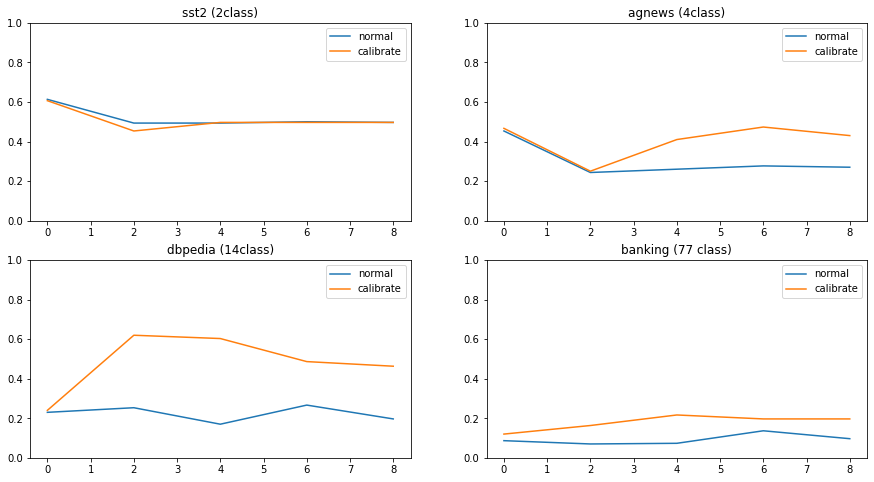

In [33]:
import matplotlib.pyplot as plt

print("GPT2-small")
fig, ax = plt.subplots(2,2,figsize=(15,8))
ax[0,0].plot(all_shots, sst2, label = "normal")
ax[0,0].plot(all_shots, cali_sst2, label = "calibrate")
ax[0,0].set_title("sst2 (2class)")
ax[0,0].legend()
ax[0,0].set_ylim([0, 1])
ax[0,1].plot(all_shots, agnews, label = "normal")
ax[0,1].plot(all_shots, cali_agnews, label = "calibrate")
ax[0,1].set_title("agnews (4class)")
ax[0,1].legend()
ax[0,1].set_ylim([0, 1])
ax[1,0].plot(all_shots, dbpedia, label = "normal")
ax[1,0].plot(all_shots, cali_dbpedia, label = "calibrate")
ax[1,0].set_title("dbpedia (14class)")
ax[1,0].legend()
ax[1,0].set_ylim([0, 1])
ax[1,1].plot(all_shots, banking, label = "normal")
ax[1,1].plot(all_shots, cali_banking, label = "calibrate")
ax[1,1].set_title("banking (77 class)")
ax[1,1].legend()
ax[1,1].set_ylim([0, 1])
plt.show()

In [34]:
import pickle
datasets = ["sst2","agnews","dbpedia","banking"]
# datasets = ["sst2"]
all_shots = [0,2,4,6,8]
sst2 = []
cali_sst2 = []
agnews = []
cali_agnews = []
dbpedia = []
cali_dbpedia = []
banking = []
cali_banking = []
for name in datasets:
    for s in all_shots:
        with open(f'./saved_results/{name}_gpt2-medium_{s}shot_300_subsample_seed0.pkl', 'rb') as f:
            data = pickle.load(f)
            # print(f"{name} {s} shots")
            # print(data["accuracies"])
            if name == "sst2":
                sst2.append(data["accuracies"][0])
                cali_sst2.append(data["accuracies"][1])
            elif name == "agnews":
                agnews.append(data["accuracies"][0])
                cali_agnews.append(data["accuracies"][1])
            elif name == "dbpedia":
                dbpedia.append(data["accuracies"][0])
                cali_dbpedia.append(data["accuracies"][1])
            elif name == "banking":
                banking.append(data["accuracies"][0])
                cali_banking.append(data["accuracies"][1])

In [35]:
results = []
for name in datasets:
    for s in all_shots:
        with open(f'./saved_results/{name}_gpt2-medium_{s}shot_300_subsample_seed0.pkl', 'rb') as f:
            data = pickle.load(f)
            # print(f"{name} {s} shots")
            # print(data["accuracies"])
            results.append([name,s,data["accuracies"][0],data["accuracies"][1]])

In [36]:
results
header = ["Datasets","num_shots","Normal_acc","Calibrated_acc"]
with open('gpt2-medium-results.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(results)

GPT2-medium


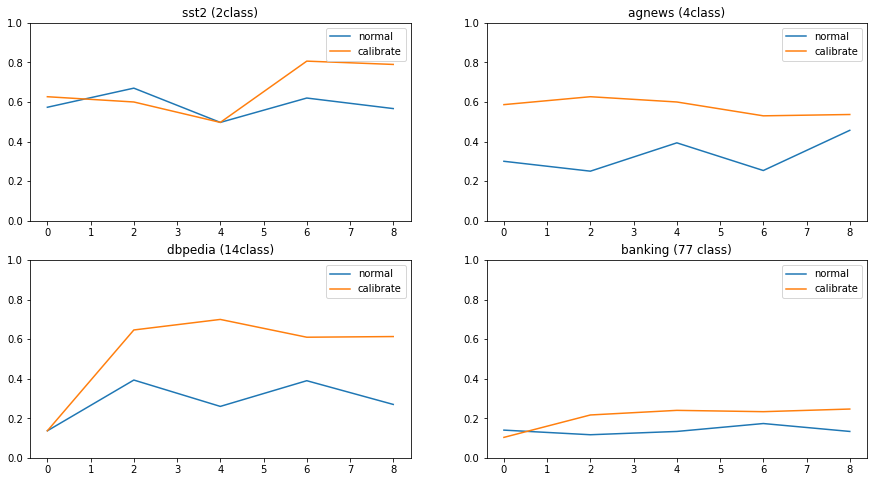

In [37]:
print("GPT2-medium")
fig, ax = plt.subplots(2,2,figsize=(15,8))
ax[0,0].plot(all_shots, sst2, label = "normal")
ax[0,0].plot(all_shots, cali_sst2, label = "calibrate")
ax[0,0].set_title("sst2 (2class)")
ax[0,0].legend()
ax[0,0].set_ylim([0, 1])
ax[0,1].plot(all_shots, agnews, label = "normal")
ax[0,1].plot(all_shots, cali_agnews, label = "calibrate")
ax[0,1].set_title("agnews (4class)")
ax[0,1].legend()
ax[0,1].set_ylim([0, 1])
ax[1,0].plot(all_shots, dbpedia, label = "normal")
ax[1,0].plot(all_shots, cali_dbpedia, label = "calibrate")
ax[1,0].set_title("dbpedia (14class)")
ax[1,0].legend()
ax[1,0].set_ylim([0, 1])
ax[1,1].plot(all_shots, banking, label = "normal")
ax[1,1].plot(all_shots, cali_banking, label = "calibrate")
ax[1,1].set_title("banking (77 class)")
ax[1,1].legend()
ax[1,1].set_ylim([0, 1])
plt.show()